### Imports and Global Settings

In [110]:
library(tidyverse)
library(colorRamps)
library(wesanderson)
library(plotly)
library(broom)
library(patchwork)
options(repr.plot.width=12, repr.plot.heigh=12)

In [111]:
my_palette <- wes_palette("FantasticFox1", 12, type = "continuous")

# Set default color and fill scales globally
update_geom_defaults("bar", list(fill = my_palette[1], color= "white"))
update_geom_defaults("col", list(fill = my_palette[2], color="white"))

scale_fill_discrete <- function(...) scale_fill_manual(values = my_palette, ...)
scale_color_discrete <- function(...) scale_color_manual(values = my_palette, ...)

In [112]:
ThemeMain<-theme( title =element_text(size=16, face='bold'),
                 axis.text.y = element_blank(), 
                 axis.text.x = element_text(color='black'),
                 axis.ticks.y = element_blank(),
                 axis.title.x = element_text(size=16,color='black',face='bold')
                 )


theme_set(theme_bw())
theme_set(ThemeMain)

### Data

In [113]:
df <- read.csv("../data/owid-energy-data.csv")  %>% drop_na()

In [114]:
head(df)

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,⋯,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bulgaria,2009,BGR,7634737,107365072896,200.106,0.041,8.078,0.062,1.310,⋯,0.000,0.005,94.656,0.320,0.662,31.435,0.24,86.696,0.567,0.327
2,Bulgaria,2010,BGR,7592271,109045211136,199.971,0.123,24.367,0.185,5.269,⋯,0.022,0.020,187.487,1.229,1.891,89.565,0.68,249.095,1.481,0.894
3,Bulgaria,2011,BGR,7543128,109435363328,5.558,0.010,25.889,0.195,7.954,⋯,0.200,0.124,26.377,0.484,2.375,114.011,0.86,314.918,1.721,1.058
4,Bulgaria,2012,BGR,7488347,110261510144,399.988,0.781,130.387,0.976,9.348,⋯,1.679,1.000,41.784,0.972,3.348,162.920,1.22,447.044,2.626,1.569
5,Bulgaria,2013,BGR,7431169,109643522048,29.912,0.292,170.692,1.268,14.803,⋯,3.231,1.915,12.500,0.396,3.743,184.359,1.37,503.742,3.185,1.890
6,Bulgaria,2014,BGR,7372142,110703534080,-0.613,-0.008,171.004,1.261,27.129,⋯,2.685,1.609,-3.126,-0.139,3.605,180.409,1.33,488.957,2.835,1.704


### Pivoting Resources

In [115]:
RESOURCES = c("biofuel", "coal", "fossil", "gas", "hydro", "low_carbon", "nuclear", "oil", "other", "solar", "wind ")

In [116]:
pal <- wes_palette("FantasticFox1", 11, type = "continuous")

In [117]:
nrow(df)

[1] 138

### Train Test Split

In [118]:
set.seed(99) 
sample <- sample(c(TRUE, FALSE), nrow(df), replace=TRUE, prob=c(0.8,0.2))
train  <- df[sample, ]
test   <- df[!sample, ]

In [119]:
nrow(train)

[1] 112

In [120]:
nrow(test)

[1] 26

In [121]:
train_pivot <- train %>%
  pivot_longer(
    cols = ends_with("_consumption"),
    names_to = "resource",
    values_to = "consumption"
  ) %>%
  mutate(
    resource = gsub("_consumption", "", resource),
  ) %>%
  filter(resource %in% RESOURCES) %>%
  group_by(resource, year) %>% 
  summarize(total_consumption = sum(consumption)) 



`summarise()` has grouped output by 'resource'. You can override using the
`.groups` argument.


In [122]:
test_pivot <- test %>%
  pivot_longer(
    cols = ends_with("_consumption"),
    names_to = "resource",
    values_to = "consumption"
  ) %>%
  mutate(
    resource = gsub("_consumption", "", resource),
  ) %>%
  filter(resource %in% RESOURCES) %>%
  group_by(resource, year) %>% 
  summarize(total_consumption = sum(consumption)) 

`summarise()` has grouped output by 'resource'. You can override using the
`.groups` argument.


In [123]:
head(train_pivot)

resource,year,total_consumption
<chr>,<int>,<dbl>
biofuel,1993,0.413
biofuel,1994,1.382
biofuel,1995,0.359
biofuel,1996,3.170
biofuel,1997,3.407
biofuel,1998,3.951


### Train Relationship

`geom_smooth()` using formula = 'y ~ x'


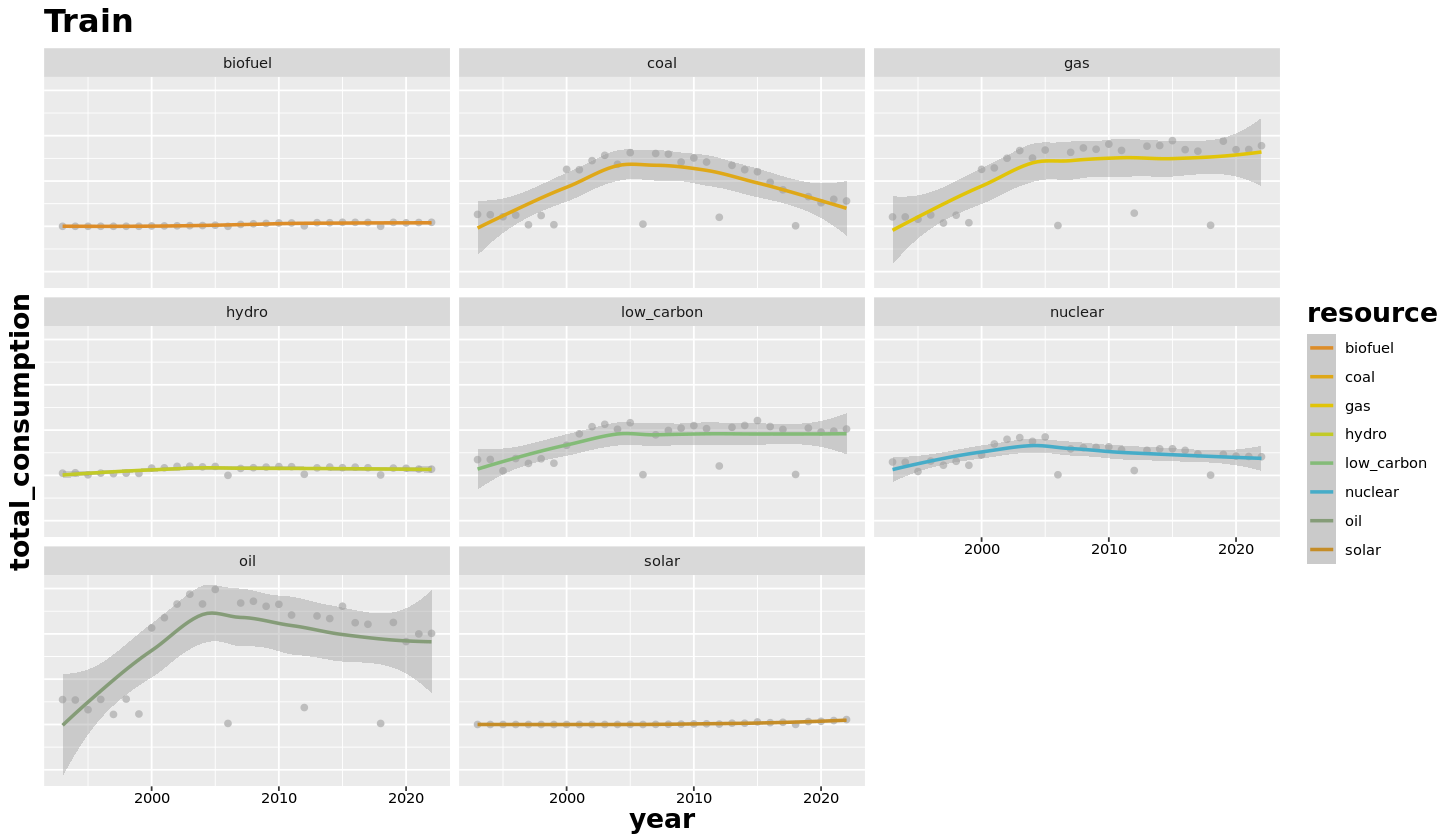

In [ ]:
p1 <- ggplot(train_pred, aes(x = year , y=total_consumption, color=resource)) +
    geom_point(color="grey") +
    geom_smooth(method="loess") +
    facet_wrap(~resource) +
    scale_color_manual(values = pal) +
    labs(title='Train Set')

### Test Relationships

In [ ]:
p2 <- ggplot(test_pred, aes(x = year , y=total_consumption, color=resource)) +
    geom_point(color="grey") +
    geom_smooth(method="loess") +
    facet_wrap(~resource) +
    scale_color_manual(values = pal) +
    labs(title='Test Set')

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


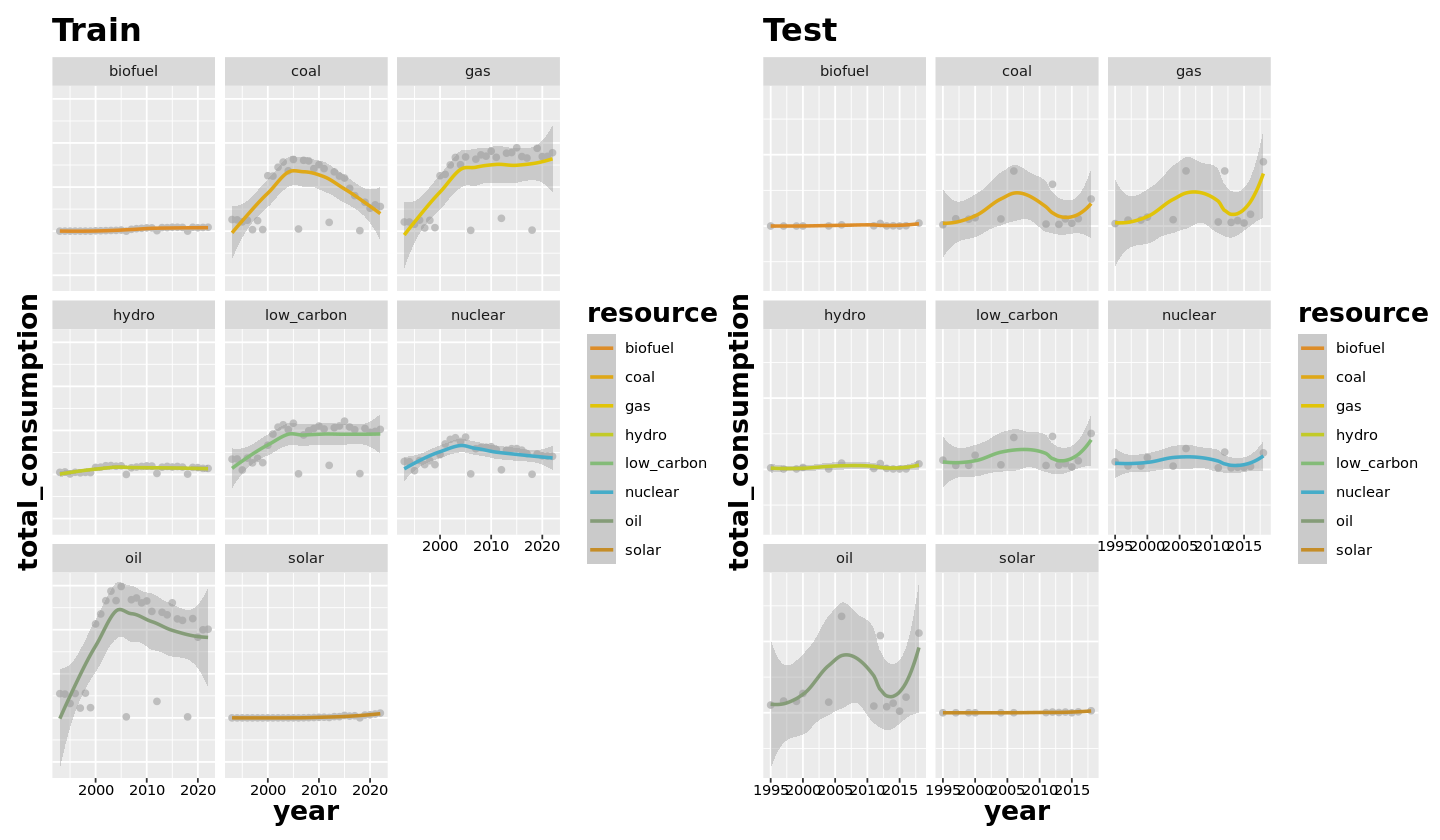

In [128]:
p1 + p2 

### Observations


We notice that that trends between year and resouce consumption are not the same between the train and test set. This could highlight the importance of different countries impact on the trend such that when sampling we ensure that countries with high and low consumption are sampled proportionately